In [1]:
import os
import re

from dotenv import find_dotenv, load_dotenv
from IPython.display import display
from rich import print as rprint
from rich.markdown import Markdown
from rich.pretty import Pretty
from rich.text import Text

In [2]:
load_dotenv(find_dotenv('.env'))

True

In [3]:
os.environ["LANGCHAIN_PROJECT"] = "RAG From Scratch: Part 7-1 (Query Translation - Decomposition (Recursive))"

# Query translation

![](images/query-translation-01.png)

![](images/query-translation-02.png)

# Part 7-1: Decomposition (Recursive)

![](images/07-01-decomposition-recursive.png)

## Configure components

In [4]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [5]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=1
)
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_3267753c5d', 'finish_reason': 'stop', 'logprobs': None}, id='run-55a3f578-0e30-41aa-bc53-e209bf82179e-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
len(embeddings.embed_query("Hello"))

1536

## Load documents

In [7]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [8]:
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
len(docs)

1

In [9]:
print(docs[0].page_content[:1000])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Memory

Short-term memory: I 

## Split documents

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [11]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
len(splits)

66

## Store documents

In [12]:
from langchain_core.vectorstores import InMemoryVectorStore

In [13]:
vectorstore = InMemoryVectorStore(embeddings)
doc_ids = vectorstore.add_documents(documents=splits)
len(doc_ids), len(vectorstore.store)

(66, 66)

In [14]:
retriever = vectorstore.as_retriever()

## RAG

In [15]:
import operator
from typing import Annotated, Literal, TypedDict

from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, StateGraph
from pydantic import BaseModel, Field

In [16]:
decomposition_prompt_template = """You are a helpful assistant that generates multiple sub-questions related to an input question.
The goal is to break down the input into a set of sub-problems / sub-questions that can be answered sequentially.
Generate multiple search queries related to: {question}"""
print(decomposition_prompt_template)

You are a helpful assistant that generates multiple sub-questions related to an input question.
The goal is to break down the input into a set of sub-problems / sub-questions that can be answered sequentially.
Generate multiple search queries related to: {question}


In [17]:
recursive_prompt_template = """Here is the question you need to answer:
<question>
{question}
</question>

Here are any available background question + answer pairs:
<question_answer_pairs>
{qa_pairs}
</question_answer_pairs>

Here is additional context relevant to the question: 
<context>
{context}
</context>

Use the above context and any background question + answer pairs to answer the question:
<question>
{question}
</question>
"""
print(recursive_prompt_template)

Here is the question you need to answer:
<question>
{question}
</question>

Here are any available background question + answer pairs:
<question_answer_pairs>
{qa_pairs}
</question_answer_pairs>

Here is additional context relevant to the question: 
<context>
{context}
</context>

Use the above context and any background question + answer pairs to answer the question:
<question>
{question}
</question>



In [18]:
def format_qa_pair(question, answer):
    return f"Question: {question}  \nAnswer:\n{answer}\n\n"

In [19]:
query = "What are the main components of an LLM-powered autonomous agent system?"

In [20]:
class State(TypedDict):
    question: str
    all_questions: list[str]
    current_question_idx: int
    qa_pairs: list[str]
    context: list[Document]
    answer: str

In [21]:
def generate_sub_questions(state: State, config: RunnableConfig) -> list[str]:
    max_generated_sub_questions_count = config['configurable'].get("max_generated_sub_questions_count", 3)
    query = state['question']
    
    class SubQuestionsGenerator(BaseModel):
        sub_questions: list[str] = Field(
            ..., 
            description="List of generated sub-problems / sub-questions",
            max_items=max_generated_sub_questions_count
        )
    
    structured_llm = llm.with_structured_output(SubQuestionsGenerator, method="function_calling")
    decomposition_prompt = decomposition_prompt_template.format(
        question=query
    )
    response = structured_llm.invoke([
        HumanMessage(content=decomposition_prompt)
    ])
    questions = response.sub_questions + [query]
    
    return {"all_questions": questions, "current_question_idx": 0}


def retrieve_docs(state: State):
    question = state["all_questions"][state["current_question_idx"]]
    retrieved_docs = vectorstore.similarity_search(question)
    return {"context": retrieved_docs}


def generate_answer(state: State):
    question = state["all_questions"][state["current_question_idx"]]
    recursive_prompt = recursive_prompt_template.format(
        question=question,
        qa_pairs=state.get("qa_pairs", ""),
        context=state["context"]
    )
    answer = llm.invoke([
        HumanMessage(content=recursive_prompt)
    ])
    qa_pair = format_qa_pair(question, answer.content)
    qa_pairs = state.get("qa_pairs", "") + qa_pair

    if state["current_question_idx"] == len(state['all_questions']) - 1:
        return {"answer": answer.content}
    else:
        return {"qa_pairs": qa_pairs, "current_question_idx": state["current_question_idx"] + 1}


def check_answer_status(state: State) -> Literal["Next sub-question", "Final answer"]:
    if state.get("answer"):
        return "Final answer"
    else:
        return "Next sub-question"

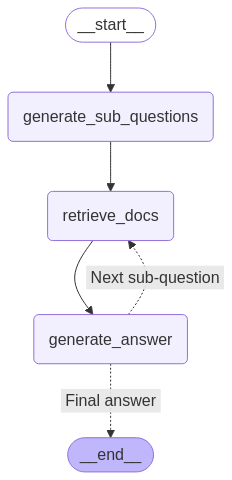

In [22]:
graph_builder = StateGraph(State)

graph_builder.add_node("generate_sub_questions", generate_sub_questions)
graph_builder.add_node("retrieve_docs", retrieve_docs)
graph_builder.add_node("generate_answer", generate_answer)

graph_builder.add_edge(START, "generate_sub_questions")
graph_builder.add_edge("generate_sub_questions", "retrieve_docs")
graph_builder.add_edge("retrieve_docs", "generate_answer")
graph_builder.add_conditional_edges(
    "generate_answer", 
    check_answer_status, 
    {
        "Next sub-question": "retrieve_docs",
        "Final answer": END
    }
)

graph = graph_builder.compile()
graph

In [23]:
config = {
    "configurable": {
        "max_generated_sub_questions_count": 3
    }
}

for stream_mode, event in graph.stream(
    {"question": query}, 
    stream_mode=["messages", "updates"],
    config=config
):
    match stream_mode:
        case "messages":
            message, metadata = event
            print(message.content, end="", flush=True)
        case "updates":
            rprint(event)

display(Markdown(event['generate_answer']['answer']))

{
    'generate_sub_questions': {
        'all_questions': [
            'What is a large language model (LLM) and how does it function?',
            'What are the essential components required for building an autonomous agent system?',
            'How do LLMs integrate with other technologies in an autonomous system?',
            'What are the main components of an LLM-powered autonomous agent system?'
        ],
        'current_question_idx': 0
    }
}

{
    'retrieve_docs': {
        'context': [
            Document(
                id='722e6b6b-580c-4ac0-9e9c-9377b0d6914f',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 
31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a 
cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring 
examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it 
can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent 
system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and 
decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of 
complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, 
learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory'
            ),
            Document(
                id='1b77dabd-3592-4f6d-b49d-f8f5e3dc85bf',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='(4) Response generation: LLM receives the execution results and provides summarized 
results to users.\nTo put HuggingGPT into real world usage, a couple challenges need to solve: (1) Efficiency 
improvement is needed as both LLM inference rounds and interactions with other models slow down the process; (2) It
relies on a long context window to communicate over complicated task content; (3) Stability improvement of LLM 
outputs and external model services.'
            ),
            Document(
                id='3b61645a-2b61-420b-bd43-6aeac6004146',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='They did an experiment on fine-tuning LLM to call a calculator, using arithmetic as a
test case. Their experiments showed that it was harder to solve verbal math problems than explicitly stated math 
problems because LLMs (7B Jurassic1-large model) failed to extract the right arguments for the basic arithmetic 
reliably. The results highlight when the external symbolic tools can work reliably, knowing when to and how to use 
the tools are crucial, determined by the LLM capability.\nBoth TALM (Tool Augmented Language Models; Parisi et al. 
2022) and Toolformer (Schick et al. 2023) fine-tune a LM to learn to use external tool APIs. The dataset is 
expanded based on whether a newly added API call annotation can improve the quality of model outputs. See more 
details in the “External APIs” section of Prompt Engineering.'
            ),
            Document(
                id='8c6aba8b-17dc-44df-b269-f2de039f9e2b',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Reliability of natural language interface: Current agent system relies on natural 
language as an interface between LLMs and external components such as memory and tools. However, the reliability of
model outputs is questionable, as LLMs may make formatting errors and occasionally exhibit rebellious behavior 
(e.g. refuse to follow an instruction). Consequently, much of the agent demo code focuses on parsing model 
output.\n\n\nCitation#\nCited as:\n\nWeng, Lilian. (Jun 2023). “LLM-powered Autonomous Agents”. Lil’Log. 
https://lilianweng.github.io/posts/2023-06-23-agent/.'
            )
        ]
    }
}

A large language model (LLM) is an advanced artificial intelligence system designed to understand and generate human-like text based on the input it receives. It functions by utilizing deep learning techniques, particularly neural networks, to analyze vast amounts of text data, which allows it to learn language patterns, grammar, facts, and various forms of knowledge. 

LLMs operate on the principles of probabilistic modeling, where they calculate the probability of a word or phrase occurring in a given context and generate responses accordingly. They are often used in various applications such as text generation, translation, summarization, and even problem-solving tasks.

In an LLM-powered autonomous agent system, the LLM acts as the core controller or "brain" of the agent. It is complemented by several key components, including:

1. **Planning**: The LLM can break down large tasks into smaller, manageable subgoals, allowing it to tackle complex tasks more efficiently.
   
2. **Refle

{
    'generate_answer': {
        'qa_pairs': 'Question: What is a large language model (LLM) and how does it function?  \nAnswer:\nA large 
language model (LLM) is an advanced artificial intelligence system designed to understand and generate human-like 
text based on the input it receives. It functions by utilizing deep learning techniques, particularly neural 
networks, to analyze vast amounts of text data, which allows it to learn language patterns, grammar, facts, and 
various forms of knowledge. \n\nLLMs operate on the principles of probabilistic modeling, where they calculate the 
probability of a word or phrase occurring in a given context and generate responses accordingly. They are often 
used in various applications such as text generation, translation, summarization, and even problem-solving 
tasks.\n\nIn an LLM-powered autonomous agent system, the LLM acts as the core controller or "brain" of the agent. 
It is complemented by several key components, including:\n\n1. **Planning**: The LLM can break down large tasks 
into smaller, manageable subgoals, allowing it to tackle complex tasks more efficiently.\n   \n2. **Reflection and 
Refinement**: The model has the capability for self-criticism and reflection, enabling it to learn from past 
actions and improve future outputs.\n\n3. **Response Generation**: After performing tasks, the LLM summarizes the 
execution results for the user, facilitating clear communication of outcomes.\n\nDespite their capabilities, LLMs 
face challenges, such as ensuring reliability in their outputs and effectively managing interactions with external 
tools and APIs. Issues like formatting errors and inconsistent behavior can arise, necessitating careful design of 
the systems that incorporate these models. Overall, LLMs represent a powerful computational tool for various 
natural language processing tasks and beyond.\n\n',
        'current_question_idx': 1
    }
}

{
    'retrieve_docs': {
        'context': [
            Document(
                id='c8dba136-1894-422b-990e-9e2ffd92fb9c',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: 
Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan 
ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for 
enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more 
test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into 
multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'
            ),
            Document(
                id='5302075d-9342-43b9-936e-4db7b2c4423f',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Fig. 13. The generative agent architecture. (Image source: Park et al. 2023)\nThis 
fun simulation results in emergent social behavior, such as information diffusion, relationship memory (e.g. two 
agents continuing the conversation topic) and coordination of social events (e.g. host a party and invite many 
others).\nProof-of-Concept Examples#\nAutoGPT has drawn a lot of attention into the possibility of setting up 
autonomous agents with LLM as the main controller. It has quite a lot of reliability issues given the natural 
language interface, but nevertheless a cool proof-of-concept demo. A lot of code in AutoGPT is about format 
parsing.\nHere is the system message used by AutoGPT, where {{...}} are user inputs:\nYou are {{ai-name}}, 
{{user-provided AI bot description}}.\nYour decisions must always be made independently without seeking user 
assistance. Play to your strengths as an LLM and pursue simple strategies with no legal complications.\n\nGOALS:'
            ),
            Document(
                id='722e6b6b-580c-4ac0-9e9c-9377b0d6914f',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 
31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a 
cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring 
examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it 
can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent 
system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and 
decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of 
complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, 
learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory'
            ),
            Document(
                id='c2912f4c-7160-4374-81f0-fc7258c6f5eb',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='}\n]\nChallenges#\nAfter going through key ideas and demos of building LLM-centered 
agents, I start to see a couple common limitations:'
            )
        ]
    }
}

To build an autonomous agent system, several essential components are required:

1. **Planning**: The agent must be capable of breaking down complex tasks into smaller, manageable subgoals. This involves task decomposition, often enhanced through techniques like the chain of thought (CoT) prompting, which encourages the model to think step by step during the execution of tasks.

2. **Reflection and Refinement**: The agent should possess the ability to self-reflect on its past actions, learn from mistakes, and refine its future strategies. This self-critical capability improves the quality and effectiveness of the agent's outputs over time.

3. **Memory**: Maintaining a memory system is crucial for remembering past interactions and decisions, allowing the agent to have context and continuity in its actions. This component aids in enhancing conversations and task management by recalling previous states and objectives.

4. **Response Generation**: After completing tasks, the agent needs t

{
    'generate_answer': {
        'qa_pairs': 'Question: What is a large language model (LLM) and how does it function?  \nAnswer:\nA large 
language model (LLM) is an advanced artificial intelligence system designed to understand and generate human-like 
text based on the input it receives. It functions by utilizing deep learning techniques, particularly neural 
networks, to analyze vast amounts of text data, which allows it to learn language patterns, grammar, facts, and 
various forms of knowledge. \n\nLLMs operate on the principles of probabilistic modeling, where they calculate the 
probability of a word or phrase occurring in a given context and generate responses accordingly. They are often 
used in various applications such as text generation, translation, summarization, and even problem-solving 
tasks.\n\nIn an LLM-powered autonomous agent system, the LLM acts as the core controller or "brain" of the agent. 
It is complemented by several key components, including:\n\n1. **Planning**: The LLM can break down large tasks 
into smaller, manageable subgoals, allowing it to tackle complex tasks more efficiently.\n   \n2. **Reflection and 
Refinement**: The model has the capability for self-criticism and reflection, enabling it to learn from past 
actions and improve future outputs.\n\n3. **Response Generation**: After performing tasks, the LLM summarizes the 
execution results for the user, facilitating clear communication of outcomes.\n\nDespite their capabilities, LLMs 
face challenges, such as ensuring reliability in their outputs and effectively managing interactions with external 
tools and APIs. Issues like formatting errors and inconsistent behavior can arise, necessitating careful design of 
the systems that incorporate these models. Overall, LLMs represent a powerful computational tool for various 
natural language processing tasks and beyond.\n\nQuestion: What are the essential components required for building 
an autonomous agent system?  \nAnswer:\nTo build an autonomous agent system, several essential components are 
required:\n\n1. **Planning**: The agent must be capable of breaking down complex tasks into smaller, manageable 
subgoals. This involves task decomposition, often enhanced through techniques like the chain of thought (CoT) 
prompting, which encourages the model to think step by step during the execution of tasks.\n\n2. **Reflection and 
Refinement**: The agent should possess the ability to self-reflect on its past actions, learn from mistakes, and 
refine its future strategies. This self-critical capability improves the quality and effectiveness of the agent\'s 
outputs over time.\n\n3. **Memory**: Maintaining a memory system is crucial for remembering past interactions and 
decisions, allowing the agent to have context and continuity in its actions. This component aids in enhancing 
conversations and task management by recalling previous states and objectives.\n\n4. **Response Generation**: After
completing tasks, the agent needs to generate clear and concise responses or summaries of its actions. This helps 
communicate the outcomes effectively to users or other systems.\n\nIncorporating these components allows for the 
creation of sophisticated autonomous agents that can perform tasks independently, adaptively, and in a 
context-aware manner.\n\n',
        'current_question_idx': 2
    }
}

{
    'retrieve_docs': {
        'context': [
            Document(
                id='722e6b6b-580c-4ac0-9e9c-9377b0d6914f',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 
31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a 
cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring 
examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it 
can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent 
system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and 
decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of 
complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, 
learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory'
            ),
            Document(
                id='c8dba136-1894-422b-990e-9e2ffd92fb9c',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: 
Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan 
ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for 
enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more 
test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into 
multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'
            ),
            Document(
                id='8c6aba8b-17dc-44df-b269-f2de039f9e2b',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Reliability of natural language interface: Current agent system relies on natural 
language as an interface between LLMs and external components such as memory and tools. However, the reliability of
model outputs is questionable, as LLMs may make formatting errors and occasionally exhibit rebellious behavior 
(e.g. refuse to follow an instruction). Consequently, much of the agent demo code focuses on parsing model 
output.\n\n\nCitation#\nCited as:\n\nWeng, Lilian. (Jun 2023). “LLM-powered Autonomous Agents”. Lil’Log. 
https://lilianweng.github.io/posts/2023-06-23-agent/.'
            ),
            Document(
                id='479fea7b-64f8-4e1f-b448-72c05a7f7660',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an 
external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition 
Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates 
the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing
“Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step 
is outsourced to an external tool, assuming the availability of domain-specific PDDL and a suitable planner which 
is common in certain robotic setups but not in many other domains.\nSelf-Reflection#\nSelf-reflection is a vital 
aspect that allows autonomous agents to improve iteratively by refining past action decisions and correcting 
previous mistakes. It 

Large language models (LLMs) integrate with other technologies in an autonomous system by serving as the core controller—often referred to as the "brain"—and collaborating with various essential components that enhance the system's capabilities. This integration is foundational in enabling the autonomous agents to perform complex tasks effectively. Here are key ways LLMs integrate with other technologies in such systems:

1. **Planning**: LLMs enable task decomposition, breaking down complex goals into smaller, manageable subgoals. This is often achieved using techniques like the Chain of Thought (CoT) prompting, which encourages the model to think step-by-step. Additionally, LLMs can interface with external planning tools. For instance, they can utilize classical planning methods through the Planning Domain Definition Language (PDDL), where an LLM translates a problem into PDDL, requests a classical planner to generate a plan, and then translates that plan back into natural language.


{
    'generate_answer': {
        'qa_pairs': 'Question: What is a large language model (LLM) and how does it function?  \nAnswer:\nA large 
language model (LLM) is an advanced artificial intelligence system designed to understand and generate human-like 
text based on the input it receives. It functions by utilizing deep learning techniques, particularly neural 
networks, to analyze vast amounts of text data, which allows it to learn language patterns, grammar, facts, and 
various forms of knowledge. \n\nLLMs operate on the principles of probabilistic modeling, where they calculate the 
probability of a word or phrase occurring in a given context and generate responses accordingly. They are often 
used in various applications such as text generation, translation, summarization, and even problem-solving 
tasks.\n\nIn an LLM-powered autonomous agent system, the LLM acts as the core controller or "brain" of the agent. 
It is complemented by several key components, including:\n\n1. **Planning**: The LLM can break down large tasks 
into smaller, manageable subgoals, allowing it to tackle complex tasks more efficiently.\n   \n2. **Reflection and 
Refinement**: The model has the capability for self-criticism and reflection, enabling it to learn from past 
actions and improve future outputs.\n\n3. **Response Generation**: After performing tasks, the LLM summarizes the 
execution results for the user, facilitating clear communication of outcomes.\n\nDespite their capabilities, LLMs 
face challenges, such as ensuring reliability in their outputs and effectively managing interactions with external 
tools and APIs. Issues like formatting errors and inconsistent behavior can arise, necessitating careful design of 
the systems that incorporate these models. Overall, LLMs represent a powerful computational tool for various 
natural language processing tasks and beyond.\n\nQuestion: What are the essential components required for building 
an autonomous agent system?  \nAnswer:\nTo build an autonomous agent system, several essential components are 
required:\n\n1. **Planning**: The agent must be capable of breaking down complex tasks into smaller, manageable 
subgoals. This involves task decomposition, often enhanced through techniques like the chain of thought (CoT) 
prompting, which encourages the model to think step by step during the execution of tasks.\n\n2. **Reflection and 
Refinement**: The agent should possess the ability to self-reflect on its past actions, learn from mistakes, and 
refine its future strategies. This self-critical capability improves the quality and effectiveness of the agent\'s 
outputs over time.\n\n3. **Memory**: Maintaining a memory system is crucial for remembering past interactions and 
decisions, allowing the agent to have context and continuity in its actions. This component aids in enhancing 
conversations and task management by recalling previous states and objectives.\n\n4. **Response Generation**: After
completing tasks, the agent needs to generate clear and concise responses or summaries of its actions. This helps 
communicate the outcomes effectively to users or other systems.\n\nIncorporating these components allows for the 
creation of sophisticated autonomous agents that can perform tasks independently, adaptively, and in a 
context-aware manner.\n\nQuestion: How do LLMs integrate with other technologies in an autonomous system?  
\nAnswer:\nLarge language models (LLMs) integrate with other technologies in an autonomous system by serving as the
core controller—often referred to as the "brain"—and collaborating with various essential components that enhance 
the system\'s capabilities. This integration is foundational in enabling the autonomous agents to perform complex 
tasks effectively. Here are key ways LLMs integrate with other technologies in such systems:\n\n1. **Planning**: 
LLMs enable task decomposition, breaking down complex goals into smaller, manageable subgoals. This is often 
achieved

{
    'retrieve_docs': {
        'context': [
            Document(
                id='722e6b6b-580c-4ac0-9e9c-9377b0d6914f',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 
31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a 
cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring 
examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it 
can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent 
system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and 
decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of 
complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, 
learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory'
            ),
            Document(
                id='c8dba136-1894-422b-990e-9e2ffd92fb9c',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: 
Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan 
ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for 
enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more 
test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into 
multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'
            ),
            Document(
                id='8c6aba8b-17dc-44df-b269-f2de039f9e2b',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Reliability of natural language interface: Current agent system relies on natural 
language as an interface between LLMs and external components such as memory and tools. However, the reliability of
model outputs is questionable, as LLMs may make formatting errors and occasionally exhibit rebellious behavior 
(e.g. refuse to follow an instruction). Consequently, much of the agent demo code focuses on parsing model 
output.\n\n\nCitation#\nCited as:\n\nWeng, Lilian. (Jun 2023). “LLM-powered Autonomous Agents”. Lil’Log. 
https://lilianweng.github.io/posts/2023-06-23-agent/.'
            ),
            Document(
                id='5302075d-9342-43b9-936e-4db7b2c4423f',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Fig. 13. The generative agent architecture. (Image source: Park et al. 2023)\nThis 
fun simulation results in emergent social behavior, such as information diffusion, relationship memory (e.g. two 
agents continuing the conversation topic) and coordination of social events (e.g. host a party and invite many 
others).\nProof-of-Concept Examples#\nAutoGPT has drawn a lot of attention into the possibility of setting up 
autonomous agents with LLM as the main controller. It has quite a lot of reliability issues given the natural 
language interface, but nevertheless a cool proof-of-concept demo. A lot of code in AutoGPT is about format 
parsing.\nHere is the system message used by AutoGPT, where {{...}} are user inputs:\nYou are {{ai-name}}, 
{{user-provided AI bot description}}.\nYour decisions must always be made independently without seeking user 
assistance. Play to your strengths as an LL

The main components of an LLM-powered autonomous agent system are:

1. **Planning**: This component allows the agent to break down complex tasks into smaller, manageable subgoals. Techniques such as the Chain of Thought (CoT) prompting help in achieving this, enabling the agent to think step-by-step and approach tasks systematically.

2. **Reflection and Refinement**: The agent possesses the ability to reflect on its past actions, learn from mistakes, and refine its strategies for future tasks. This self-critical capability improves the quality and effectiveness of the agent's output over time.

3. **Memory**: A memory system is essential for maintaining context and continuity in the agent's actions. This allows the agent to remember past interactions and decisions, enhancing its ability to manage tasks and engage in conversations.

4. **Response Generation**: After completing tasks, the agent generates clear and concise summaries of its actions. This communication capability is vital 

{
    'generate_answer': {
        'answer': "The main components of an LLM-powered autonomous agent system are:\n\n1. **Planning**: This 
component allows the agent to break down complex tasks into smaller, manageable subgoals. Techniques such as the 
Chain of Thought (CoT) prompting help in achieving this, enabling the agent to think step-by-step and approach 
tasks systematically.\n\n2. **Reflection and Refinement**: The agent possesses the ability to reflect on its past 
actions, learn from mistakes, and refine its strategies for future tasks. This self-critical capability improves 
the quality and effectiveness of the agent's output over time.\n\n3. **Memory**: A memory system is essential for 
maintaining context and continuity in the agent's actions. This allows the agent to remember past interactions and 
decisions, enhancing its ability to manage tasks and engage in conversations.\n\n4. **Response Generation**: After 
completing tasks, the agent generates clear and concise summaries of its actions. This communication capability is 
vital for effectively conveying outcomes to users or other systems.\n\nEach of these components plays a significant
role in creating a sophisticated and adaptable autonomous agent that can perform tasks independently and 
contextually."
    }
}

The main components of an LLM-powered autonomous agent system are:                                                 

 1 Planning: This component allows the agent to break down complex tasks into smaller, manageable subgoals.        
   Techniques such as the Chain of Thought (CoT) prompting help in achieving this, enabling the agent to think     
   step-by-step and approach tasks systematically.                                                                 
 2 Reflection and Refinement: The agent possesses the ability to reflect on its past actions, learn from mistakes, 
   and refine its strategies for future tasks. This self-critical capability improves the quality and effectiveness
   of the agent's output over time.                                                                                
 3 Memory: A memory system is essential for maintaining context and continuity in the agent's actions. This allows 
   the agent to remember past interactions and decisions, enhancing its ability to manage tasks and engage in      
   conversations.                                                                                                  
 4 Response Generation: After completing tasks, the agent generates clear and concise summaries of its actions.    
   This communication capability is vital for effectively conveying outcomes to users or other systems.            

Each of these components plays a significant role in creating a sophisticated and adaptable autonomous agent that  
can perform tasks independently and contextually.